# **WHICH TERMINOLOGY IS RELEVANT FOR HATE SPEECH AND WHICH FOR OFFENSIVE LANGUAGE?**

TMSA Project: *I hate you*

Nicolò Pignatelli

In [ ]:
# some installations apparaently needed every new run time

!pip install shap
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
# libraries

import re
import nltk
import shap
import random
import inflect
import numpy as np
import contractions
import pandas as pd
import xgboost as xgb
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# importing the dataset directly from github repository (https://github.com/t-davidson/hate-speech-and-offensive-language)

!wget https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv

--2024-08-22 09:59:37--  https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546446 (2.4M) [text/plain]
Saving to: ‘labeled_data.csv’

labeled_data.csv    100%[===================>]   2.43M  --.-KB/s    in 0.05s   

2024-08-22 09:59:38 (46.8 MB/s) - ‘labeled_data.csv’ saved [2546446/2546446]



In [ ]:
# importing the dataset -> very popular one (Davidson et al.)
# platform of the sample: Twitter

raw_df = pd.read_csv("/content/labeled_data.csv")
raw_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# class may be a problematic name for a column

raw_df.rename(columns = {"class" : "label"}, inplace = True)

In [ ]:
# for now the important columns are:
# class: 0 is the label for hate speech, 1 for offensive language, 2 for neither
# tweet
# how many rows and columns?

nrows, ncols = raw_df.shape
print(nrows, ncols)

24783 7


In [ ]:
# we do not need all the columns

raw_df = raw_df[['label', 'tweet']]
raw_df.head()

,label,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# are there any na values?

raw_df.isna().any()

,0
label,False
tweet,False


In [ ]:
# let's check if the types of the data are all fine

raw_df.dtypes

,0
label,int64
tweet,object


In [ ]:
# are there any tweets that are not strings?

raw_df.tweet.apply(lambda x: type(x) == str).value_counts()

,count
tweet,
True,24783


In [ ]:
# They are all strings
# Let's now see the distribution of the labels

label_count = raw_df.label.value_counts().sort_index()
print(label_count)

label
0     1430
1    19190
2     4163
Name: count, dtype: int64


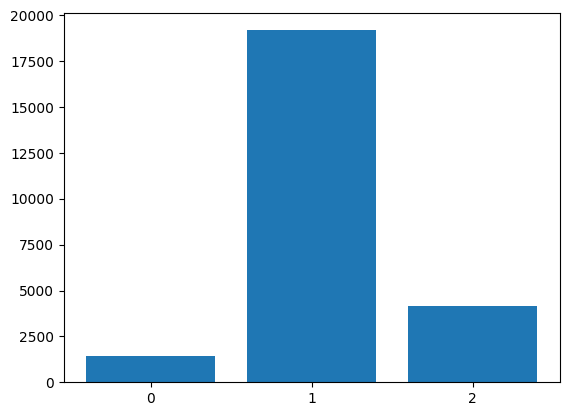

In [ ]:
# there is class imbalance -> to take into account later
# let's plot the counts of the labels

plt.bar(label_count.index, label_count.values)
plt.xticks(ticks = label_count.index)
plt.show()

**EXPLORATORY ANALYSIS AND TEXT PREPROCESSING**

In [ ]:
# copying the dataset to preserve the original one

df = raw_df.copy()
df.head()

,label,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# let's start by having an idea of our data

char_count = df.tweet.apply(lambda x: len(x))
char_mean = np.mean(char_count)
print("Average number of chars in a tweet:",char_mean)

Average number of chars in a tweet: 85.43606504458701


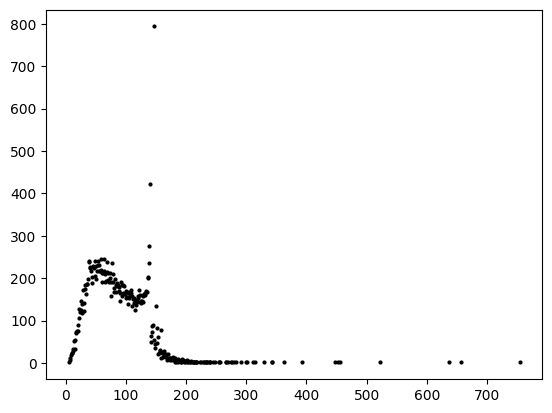

In [ ]:
# let's see the distribution

char_table = char_count.value_counts().sort_index()
plt.plot(char_table.index, char_table.values, 'o', markersize = 2, color = 'black')
plt.show()

In [ ]:
# which is the most common length? Probably related to the old limit of Twitter

max_char = char_table.values.max()
char_common_len = char_table.index[char_table.values == max_char][0]
print("There are",max_char,"tweets with a length of",char_common_len,"chars")

There are 794 tweets with a length of 146 chars


A lot of preprocessing techniques. According to literature reviewed, to do:
- lowercase
- hashtags removal
- URLs removal
- mentions tokenization
- digits conversion to word
- punctuation removal
- char repetitions removal
- expanding contractions
- tokenization
- removing stopwords
- stemming

In [ ]:
# 1. lowercasing

df.tweet = df.tweet.apply(lambda tweet: tweet.lower())
df.head()

,label,tweet
0,2,!!! rt @mayasolovely: as a woman you shouldn't...
1,1,!!!!! rt @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...
3,1,!!!!!!!!! rt @c_g_anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! rt @shenikaroberts: the shit you...


In [ ]:
# 2. hashtags removal. Is there any?

print(df.tweet.apply(lambda tweet: bool(re.search(r'#\w+', tweet))).value_counts())

tweet
False    17149
True      7634
Name: count, dtype: int64


In [ ]:
# Remove them

df.tweet = df.tweet.apply(lambda tweet: re.sub(r'#\w+', '', tweet).strip())

In [ ]:
# 3. URLs removal. Is there any?

print(df.tweet.apply(lambda tweet: bool(re.search(r'http[s]?://\S+', tweet))).value_counts())

tweet
False    21799
True      2984
Name: count, dtype: int64


In [ ]:
# Remove them

df.tweet = df.tweet.apply(lambda tweet: re.sub(r'http[s]?://\S+', '', tweet).strip())

In [ ]:
# 4. Mentions: how many of them?

print(df.tweet.apply(lambda tweet: bool(re.search(r'@\w+', tweet))).value_counts())

tweet
True     14189
False    10594
Name: count, dtype: int64


In [ ]:
# Almost half of the tweets contain a mention. Let's tokenize them but remove rt as probably unnecessary

df.tweet = df.tweet.apply(lambda tweet: re.sub(r'@\w+', 'SPECIALTOKEN', tweet).strip())
df.tweet = df.tweet.apply(lambda tweet: re.sub(r'\brt\b', '', tweet).strip())
df.head()

,label,tweet
0,2,!!! SPECIALTOKEN: as a woman you shouldn't co...
1,1,!!!!! SPECIALTOKEN: boy dats cold...tyga dwn ...
2,1,!!!!!!! SPECIALTOKEN dawg!!!! SPECIALTOKEN: ...
3,1,!!!!!!!!! SPECIALTOKEN: SPECIALTOKEN she look...
4,1,!!!!!!!!!!!!! SPECIALTOKEN: the shit you hear...


In [ ]:
# 5. converting digits into words

p = inflect.engine()

def num_to_word(tweet):
    return re.sub(r'\d+', lambda digit: p.number_to_words(digit.group()), tweet).strip()

df.tweet = df.tweet.apply(num_to_word)

In [ ]:
# Now I can 6. punctuation removal + \n

df.tweet = df.tweet.apply(lambda tweet: re.sub(r'[^a-zA-Z\s]', '', tweet).replace('\n', ' ').strip())
df.head()

,label,tweet
0,2,SPECIALTOKEN as a woman you shouldnt complain ...
1,1,SPECIALTOKEN boy dats coldtyga dwn bad for cuf...
2,1,SPECIALTOKEN dawg SPECIALTOKEN you ever fuck ...
3,1,SPECIALTOKEN SPECIALTOKEN she look like a tranny
4,1,SPECIALTOKEN the shit you hear about me might ...


In [ ]:
# 7. char repetitions removal
# I keep chars if they are repeated once as there are common words like this

df.tweet = df.tweet.apply(lambda tweet: re.sub(r'(.)\1{2,}', r'\1', tweet).strip())

In [ ]:
# is there any undesired char left?

def find_other_chars(tweet):
  char = re.search(r'[^a-zA-Z ]', tweet)
  if char != None:
    return(tweet)
  else:
    return("all fine")

df.tweet.apply(find_other_chars).value_counts()

,count
tweet,
all fine,24783


In [ ]:
# 8. expanding contractions

df.tweet = df.tweet.apply(lambda tweet: contractions.fix(tweet))

In [ ]:
# 9. tokenization

df.tweet = df.tweet.apply(lambda tweet: word_tokenize(tweet))

In [ ]:
# 10. removing stopwords

def stop_removing(tweet):

  new_tweet = []

  stop_words = set(stopwords.words('english'))

  for word in tweet:

    if word not in stop_words:
      new_tweet.append(word)

  return new_tweet

df.tweet = df.tweet.apply(stop_removing)

In [ ]:
# Last technique: 11. stemming

stemmer = SnowballStemmer("english")

stemmed_tweets = []

for tweet in df.tweet:
  stemmed_tweet = []
  for word in tweet:
    stemmed_word = stemmer.stem(word)
    stemmed_tweet.append(stemmed_word)
  stemmed_tweets.append(stemmed_tweet)


df['tweets'] = stemmed_tweets

In [ ]:
# Now I keep only the column with stemmed tweets

df = df[['label', 'tweets']]
df.head()

,label,tweets
0,2,"[specialtoken, woman, complain, clean, hous, a..."
1,1,"[specialtoken, boy, dat, coldtyga, dwn, bad, c..."
2,1,"[specialtoken, dawg, specialtoken, ever, fuck,..."
3,1,"[specialtoken, specialtoken, look, like, tranni]"
4,1,"[specialtoken, shit, hear, might, true, might,..."


In [ ]:
# last check if all is fine: is there any empty list?

empty_tweets = []

for index,tweet in df.tweets.items():
  if tweet == []:
    empty_tweets.append(index)

print("Empty lists are:",len(empty_tweets))

df = df.drop(empty_tweets).reset_index(drop = True)

print("All dropped")

Empty lists are: 8
All dropped


On average, there are 7.963188698284561 words / tokens per tweet



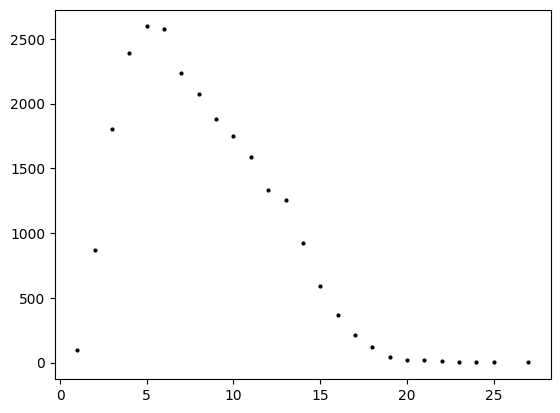


There are 2596 tweets with a number of words / tokens equal to 5


In [ ]:
# now that I have preprocessed, how many tokens / word per tweet?

word_count = df.tweets.apply(lambda x: len(x))
word_mean = np.mean(word_count)
print("On average, there are",word_mean,"words / tokens per tweet")
print()
word_table = word_count.value_counts().sort_index()
plt.plot(word_table.index, word_table.values, 'o', markersize = 2, color = 'black')
plt.show()
print()
max_word = word_table.values.max()
word_common_len = word_table.index[word_table.values == max_word][0]
print("There are",max_word,"tweets with a number of words / tokens equal to",word_common_len)

# **MACHINE LEARNING**

In [ ]:
# first of all, let's split training and test set

X_train, X_test, y_train, y_test = train_test_split(df.tweets, df.label, test_size=0.035, random_state=42)

In [ ]:
# now: there is class imbalance -> undersample

y_train.value_counts()

,count
label,
1,18528
2,4016
0,1363


In [ ]:
# undersampling label 1, discarding 85%

X_tr = []
y_tr = []

random.seed(14)

for x,y in zip(X_train, y_train):

  prob = random.random() #generate a number between 0 and 1

  if y == 1:
    if prob <= 0.15:
      X_tr.append(x)
      y_tr.append(y)

  else:
    X_tr.append(x)
    y_tr.append(y)


y_tr = pd.Series(y_tr)
X_tr = pd.Series(X_tr)

y_tr.value_counts()

,count
2,4016
1,2748
0,1363


**TF-IDF**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    min_df = 0.001, # trying to reduce the noise: the token has to appear in at least 0.1% of the tweets to be included in TF-IDF Matrix (cut-off)
    analyzer = 'word', # text units are words
    tokenizer = lambda x: x, # my text is already tokenized
    preprocessor = lambda x: x, #my text is already processed
    token_pattern = None, # I already have my tokens
    )

In [ ]:
# processing data -> crucial step, explained in the paper

X_tr_tfidf = tfidf_vectorizer.fit_transform(X_tr)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# a taste of the TF-IDF matrix

feature_names = tfidf_vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(X_tr_tfidf.toarray(), columns=feature_names)

print(df_tfidf)

      abo  absolut  account  across  act  actual   ad  adult   af  ago  ...  \
0     0.0      0.0      0.0     0.0  0.0     0.0  0.0    0.0  0.0  0.0  ...   
1     0.0      0.0      0.0     0.0  0.0     0.0  0.0    0.0  0.0  0.0  ...   
2     0.0      0.0      0.0     0.0  0.0     0.0  0.0    0.0  0.0  0.0  ...   
3     0.0      0.0      0.0     0.0  0.0     0.0  0.0    0.0  0.0  0.0  ...   
4     0.0      0.0      0.0     0.0  0.0     0.0  0.0    0.0  0.0  0.0  ...   
...   ...      ...      ...     ...  ...     ...  ...    ...  ...  ...  ...   
8122  0.0      0.0      0.0     0.0  0.0     0.0  0.0    0.0  0.0  0.0  ...   
8123  0.0      0.0      0.0     0.0  0.0     0.0  0.0    0.0  0.0  0.0  ...   
8124  0.0      0.0      0.0     0.0  0.0     0.0  0.0    0.0  0.0  0.0  ...   
8125  0.0      0.0      0.0     0.0  0.0     0.0  0.0    0.0  0.0  0.0  ...   
8126  0.0      0.0      0.0     0.0  0.0     0.0  0.0    0.0  0.0  0.0  ...   

      yellow  yes  yesterday  yet   yo  york  young

On average, there are 4.663971248876909 chars per word



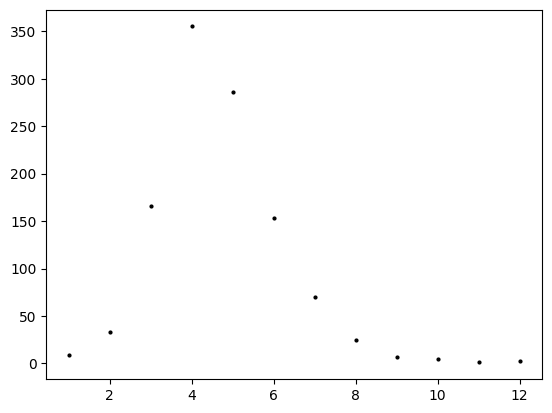


There are 355 words with a number of chars equal to 4


In [ ]:
# studying my vocabulary

terms = list(df_tfidf.columns)

term_count = pd.Series(len(term) for term in terms)

term_mean = np.mean(term_count)
print("On average, there are",term_mean,"chars per word")
print()
term_table = term_count.value_counts().sort_index()
plt.plot(term_table.index, term_table.values, 'o', markersize = 2, color = 'black')
plt.show()
print()
max_term = term_table.values.max()
term_common_len = term_table.index[term_table.values == max_term][0]
print("There are",max_term,"words with a number of chars equal to",term_common_len)

In [ ]:
# same otput in a table

term_table

,count
1,9
2,33
3,166
4,355
5,286
6,153
7,70
8,25
9,7
10,5


In [ ]:
# creating the validation set for training the model

X_training, X_val, y_training, y_val = train_test_split(X_tr_tfidf, y_tr, test_size = 0.035, random_state = 42)

**XGBoost**

In [ ]:
# instancing the model

dtrain = xgb.DMatrix(X_training, y_training)
dtest = xgb.DMatrix(X_test_tfidf, y_test)
dval = xgb.DMatrix(X_val, y_val)

params = {"objective":"multi:softprob", "num_class":3, "eval_metric":"merror"}

evals = [(dtrain, "train"), (dval, "validation")]

In [ ]:
# I want to maximize the ability of my classifier to detect hate -> custom function

def custom_f1_hate(y_pred, dtrain):

    y_true = dtrain.get_label()
    y_pred_class = np.argmax(y_pred, axis=1)
    f1_hate = f1_score(y_true, y_pred_class, labels=[0], average='macro')
    return "f1_hate", f1_hate

In [ ]:
# training the model

xgb_model = xgb.train(
   params = params,
   dtrain = dtrain,
   num_boost_round = 75,
   evals = evals,
   verbose_eval = 5,
   custom_metric = custom_f1_hate
)

[0]	train-merror:0.16157	train-f1_hate:0.59184	validation-merror:0.16842	validation-f1_hate:0.51351
[5]	train-merror:0.15175	train-f1_hate:0.60768	validation-merror:0.17193	validation-f1_hate:0.46575
[10]	train-merror:0.13951	train-f1_hate:0.63408	validation-merror:0.15088	validation-f1_hate:0.51351
[15]	train-merror:0.13007	train-f1_hate:0.66543	validation-merror:0.14737	validation-f1_hate:0.52632
[20]	train-merror:0.12114	train-f1_hate:0.69050	validation-merror:0.15088	validation-f1_hate:0.51948
[25]	train-merror:0.11375	train-f1_hate:0.71333	validation-merror:0.14386	validation-f1_hate:0.56790
[30]	train-merror:0.10839	train-f1_hate:0.73386	validation-merror:0.14035	validation-f1_hate:0.58537
[35]	train-merror:0.10418	train-f1_hate:0.74151	validation-merror:0.14386	validation-f1_hate:0.58823
[40]	train-merror:0.10074	train-f1_hate:0.74946	validation-merror:0.14386	validation-f1_hate:0.59770
[45]	train-merror:0.09844	train-f1_hate:0.75815	validation-merror:0.14386	validation-f1_hate:

In [ ]:
# testing

y_pred_proba = xgb_model.predict(dtest)
y_pred = y_pred_proba.argmax(axis=1)

In [ ]:
# now for convenience I convert my int labels into strings

label_mapping = {0:'hate', 1:'off', 2:'neither'}

pred_label = [label_mapping[label] for label in y_pred]
y_label = [label_mapping[label] for label in y_test]

In [ ]:
# how good is the model?

accuracy = accuracy_score(y_label, pred_label)
print("Accuracy:",accuracy)
print()

print(classification_report(y_label, pred_label))
print()

conf_matrix = confusion_matrix(y_label, pred_label)
print('Confusion Matrix:',conf_matrix)

Accuracy: 0.8640552995391705

              precision    recall  f1-score   support

        hate       0.46      0.65      0.54        66
     neither       0.72      0.96      0.83       143
         off       0.97      0.86      0.92       659

    accuracy                           0.86       868
   macro avg       0.72      0.82      0.76       868
weighted avg       0.89      0.86      0.87       868


Confusion Matrix: [[ 43  11  12]
 [  2 137   4]
 [ 48  41 570]]


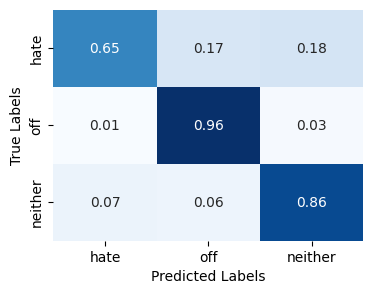

In [ ]:
# plotting the confusion matrix as Davidson et al. in their paper

plt.figure(figsize=(4,3))

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels = label_mapping.values(), yticklabels = label_mapping.values())

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

# **MOST RELEVANT TERMINOLOGY with SHAP**

In [ ]:
# converting TF-IDF matrix to a usual matrix -> needed for using SHAP

data = X_training.toarray()
labels = X_test_tfidf.toarray()

In [ ]:
# instancing shap

explainer = shap.Explainer(xgb_model, data)
shap_values = explainer(labels)

In [ ]:
# to plot the names of the tokens

shap_values.feature_names = tfidf_vectorizer.get_feature_names_out()

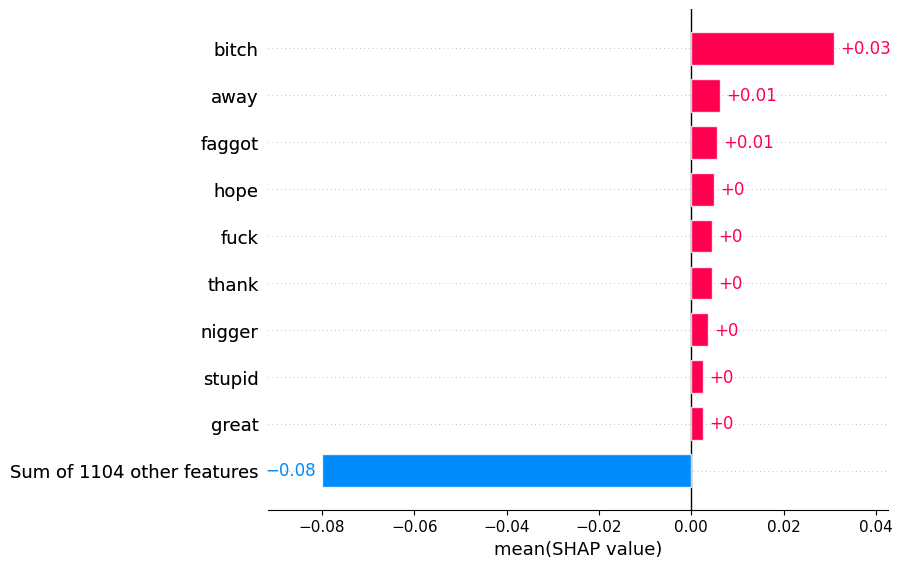

In [ ]:
# hate class plot

shap.plots.bar(shap_values[:, :, 0].mean(0), order=shap.Explanation.argsort.flip)

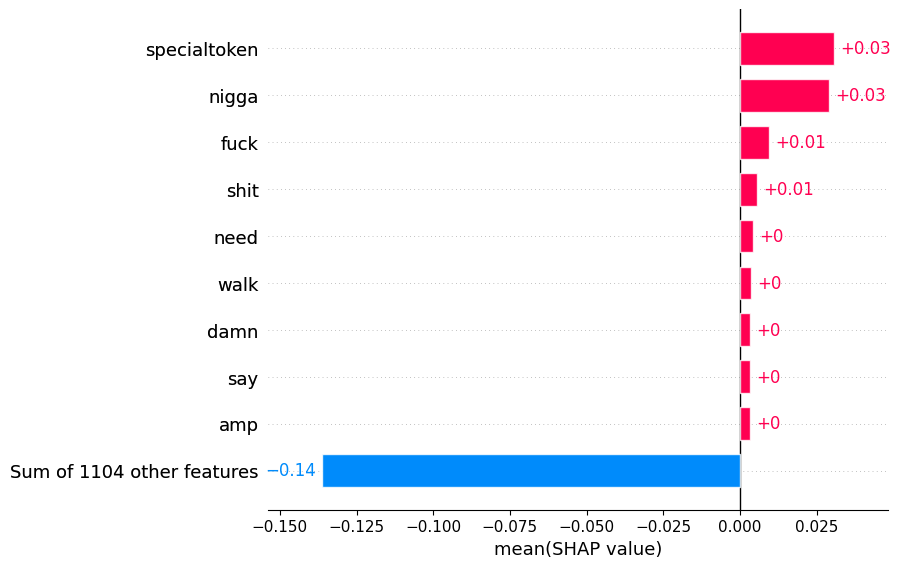

In [ ]:
# offensive class plot

shap.plots.bar(shap_values[:, :, 1].mean(0), order=shap.Explanation.argsort.flip)

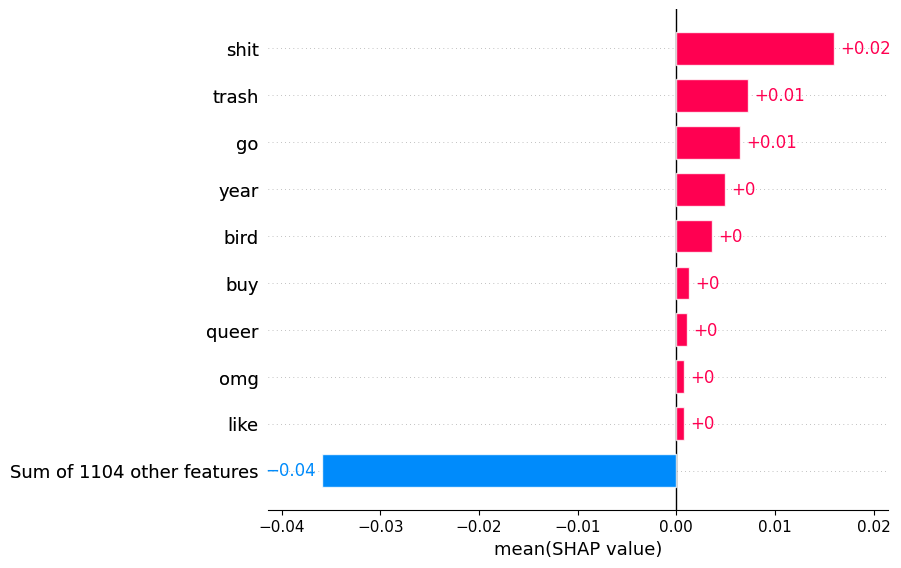

In [ ]:
# neither class plot

shap.plots.bar(shap_values[:, :, 2].mean(0), order=shap.Explanation.argsort.flip)